In [144]:
import matplotlib.pyplot as plt
import networkx as nx
import yaml
import networkx.drawing.nx_agraph as nx_agraph
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

from IPython.display import display

# Setup for displaying matplotlib plots in Jupyter Notebook
%matplotlib inline

# Additional setup for interactive widgets if needed
import ipywidgets as widgets

In [14]:
def add_edges(tree, parent=None, G=None):
    if G is None:
        G = nx.DiGraph()
    if isinstance(tree, list):
        for item in tree:
            if isinstance(item, list):
                
            else:
                node, prob = item
                G.add_node(node, title=node)
                if parent is not None:
                    G.add_edge(parent, node, probability=prob)
    return G



In [136]:
raw_tree = """
- The
- 1
- - first
  - .15
- - second
  - .05
- - date
  - .8
  - - of
    - 1
    - - the
      - 1
      - - first
        - .25
      - - second
        - .75
"""
raw_tree = yaml.load(raw_tree, Loader=Loader)
raw_tree

['The',
 1,
 ['first', 0.15],
 ['second', 0.05],
 ['date', 0.8, ['of', 1, ['the', 1, ['first', 0.25], ['second', 0.75]]]]]

In [170]:
import networkx.convert as nxc
import time

def add_node(raw_node, G=None, parent=None, cur_prob=1, depth=0):
  if G is None:
    G = nx.DiGraph() 
  title, prob, *children = raw_node
  new_node = f"{title}({depth})"
  net_prob = cur_prob * prob
  G.add_node(new_node, title=title, net_probability=net_prob)
  if parent is not None:
    G.add_edge(parent, new_node, probability=prob)
  for child in children:
    add_node(child, G, new_node, depth=depth+1, cur_prob=net_prob)
  return G

{'The(0)': (0, 0), 'first(1)': (10, 33.333333333333336), 'second(1)': (10, -0.0), 'date(1)': (10, -33.333333333333336), 'of(2)': (20, -33.333333333333336), 'the(3)': (30, -33.333333333333336), 'first(4)': (40, -25.0), 'second(4)': (40, -41.66666666666667)}


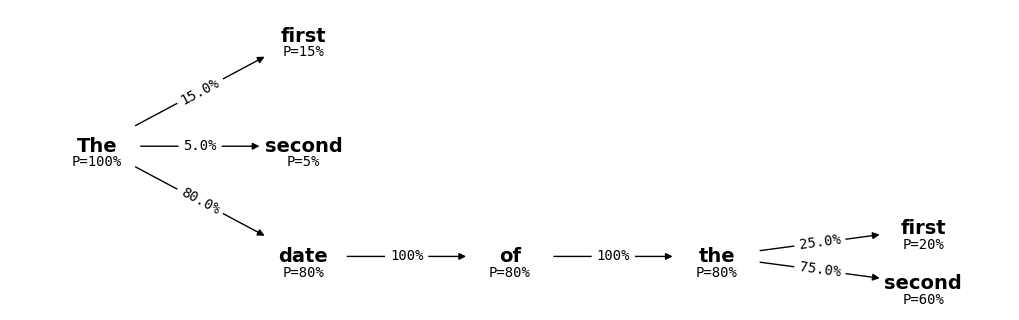

In [257]:
def hierarchy_pos(G, root=None, width=100, vert_gap=10, vert_loc=0, xcenter=0):
    """
    Creates a layout for a tree that is displayed horizontally.
    """
    if root is None:
        root = next(iter(G.nodes))

    def _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter, pos=None):
        if pos is None:
            pos = {root: (vert_loc, -xcenter)}
        else:
            pos[root] = (vert_loc, -xcenter)

        children = list(G.successors(root))
        if len(children) != 0:
            dx = width / len(children)
            nextx = xcenter - width / 2 - dx / 2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(
                    G, 
                    child, 
                    width=dx,
                    vert_gap=vert_gap,
                    vert_loc=vert_loc + vert_gap, 
                    xcenter=nextx,
                    pos=pos)
        return pos

    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

def render_tree(root, tree):
    plt.figure(3,figsize=(10,3)) 
    G = tree
    pos = hierarchy_pos(G, root=root) 
    main_labels = {node: f"{G.nodes[node]['title']}" for node in G.nodes()}
    prob_labels = {node: f"\n\nP={G.nodes[node]['net_probability']*100:0.0f}%" for node in G.nodes()}
    node_shape='s', 
    node_size=[(1000, 500) for node in G.nodes()]
    print(pos)
    nx.draw(
        G, pos, 
        labels=main_labels, 
        with_labels=True, 
        node_color='none', 
        node_size=4000,
        arrows=True,
        font_size=14, 
        font_color='black', 
        font_family='sans-serif',
        font_weight='bold',
    )
    edge_labels = {(u, v): f"{G.edges[u, v]['probability']*100}%" for u, v in G.edges}
    nx.draw_networkx_edge_labels(
        G, pos, 
        edge_labels=edge_labels,
        font_family='monospace',
    )
    nx.draw(
        G, 
        {k:(x,y) for k, (x,y) in pos.items()}, 
        labels=prob_labels, 
        with_labels=True, 
        node_color='none', 
        node_size=1500,
        edgelist=[],
        arrows=True,
        font_size=10, 
        font_color='black', 
        font_family='monospace'
    )
    
    # Show the plot
    plt.show()
tree = add_node(raw_tree)
render_tree("The(0)", tree)

In [135]:
import networkx.convert as nxc
nx.to_dict_of_dicts(tree)

{'the(0)': {'first(1)': {'probability': 0.15},
  'second(1)': {'probability': 0.05},
  'date(1)': {'probability': 0.8}},
 'first(1)': {},
 'second(1)': {},
 'date(1)': {'of(2)': {'probability': 1}},
 'of(2)': {'the(3)': {'probability': 1}},
 'the(3)': {'first(4)': {'probability': 0.25},
  'second(4)': {'probability': 0.75}},
 'first(4)': {},
 'second(4)': {}}